### Import modules and packages

In [15]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('C:/Users/sebas/git')

import numpy as np
import os
import glob
import pandas as pd 
import h5py
import pickle
import cv2 as cv

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors 
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

import scipy.signal as signal
from scipy.interpolate import LinearNDInterpolator, griddata
from datetime import datetime,timedelta
import pytz

import icewave.tools.matlab2python as mat2py
import icewave.sebastien.set_graphs as set_graphs
import icewave.drone.drone_projection as dp
import icewave.tools.matlab_colormaps as matcmaps
import icewave.tools.rw_data as rw

# PARULA COLORMAP 
parula_map = matcmaps.parula()

plt.rc('text', usetex=True)
plt.rc('font', family='serif', serif='Computer Modern')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import buoys data

In [16]:
date = '0226'
base = f'K:/Share_hublot/Data/'
path2buoys = f'{base}{date}/BoueeVague/'

filelist = glob.glob(f'{path2buoys}**/mat/*.mat',recursive = True)

In [12]:
file2load = filelist[0]


1800
B1_1800


In [3]:
data_buoy = {}

for i in range(len(filelist)):
    file2load = filelist[i]
    with h5py.File(file2load, 'r') as fmat:
        print('Top-level keys : ', list(fmat.keys()))

        # create a key
        name_split = file2load.split('\\')
        acqu = name_split[-1].split('_')[-1][:4]
        key_buoy = name_split[1] + '_' + acqu
        
        data_buoy[key_buoy] = mat2py.mat_to_dict(fmat['IMU'],fmat['IMU'])

Top-level keys :  ['#refs#', 'IMU']
Top-level keys :  ['#refs#', 'IMU']
Top-level keys :  ['#refs#', 'IMU']
Top-level keys :  ['#refs#', 'IMU']
Top-level keys :  ['#refs#', 'IMU']
Top-level keys :  ['#refs#', 'IMU']
Top-level keys :  ['#refs#', 'IMU']
Top-level keys :  ['#refs#', 'IMU']
Top-level keys :  ['#refs#', 'IMU']
Top-level keys :  ['#refs#', 'IMU']
Top-level keys :  ['#refs#', 'IMU']
Top-level keys :  ['#refs#', 'IMU']
Top-level keys :  ['#refs#', 'IMU']
Top-level keys :  ['#refs#', 'IMU']
Top-level keys :  ['#refs#', 'IMU']
Top-level keys :  ['#refs#', 'IMU']


In [4]:
UTC_buoy = {}
u_buoy = {}

# build a filter for buoys
fs = 50 # sampling frequency
fc = 0.05 # cutoff frequency
order_filter = 4
b,a = signal.butter(order_filter,fc,'high',fs = fs)

# define acceleration keys
key_accel = ['ACCEL_X','ACCEL_Y','ACCEL_Z']
key_ufield = ['ux','uy','uz']
for key in data_buoy.keys():
    
    UTC_buoy[key] = []
    # Build UTC time for buoys
    Y = int(data_buoy[key]['UTC_TIME']['YEAR'][0])
    M = int(data_buoy[key]['UTC_TIME']['MONTH'][0])
    D = int(data_buoy[key]['UTC_TIME']['DAY'][0])
    H = int(data_buoy[key]['UTC_TIME']['HOUR'][0])
    MIN = int(data_buoy[key]['UTC_TIME']['MIN'][0])
    SEC = int(data_buoy[key]['UTC_TIME']['SEC'][0])

    # initial UTC time for buoys
    UTC0 = datetime(Y,M,D,H,MIN,SEC)
    t0_epoch = UTC0.timestamp()
    t_epoch = t0_epoch + data_buoy[key]['IMU_DATA']['t']

    for t in t_epoch:
        if not np.isnan(t):
            UTC_buoy[key].append(datetime.fromtimestamp(t).replace(tzinfo = pytz.utc))

    mask = ~np.isnan(t_epoch)

    # u_buoy[key] = {}
    current_u = np.array([data_buoy[key]['IMU_DATA'][key_a][mask] for key_a in key_accel])
    # Apply filter to signal 
    current_u = signal.filtfilt(b,a,current_u,axis = -1)
    # Compute vertical velocity
    u_buoy[key] = np.cumsum(current_u - np.mean(current_u,axis = -1,keepdims = True),axis = -1)/fs

0
0
4
1
8
2
12
3
1
0
5
1
9
2
13
3
2
0
6
1
10
2
14
3
3
0
7
1
11
2
15
3


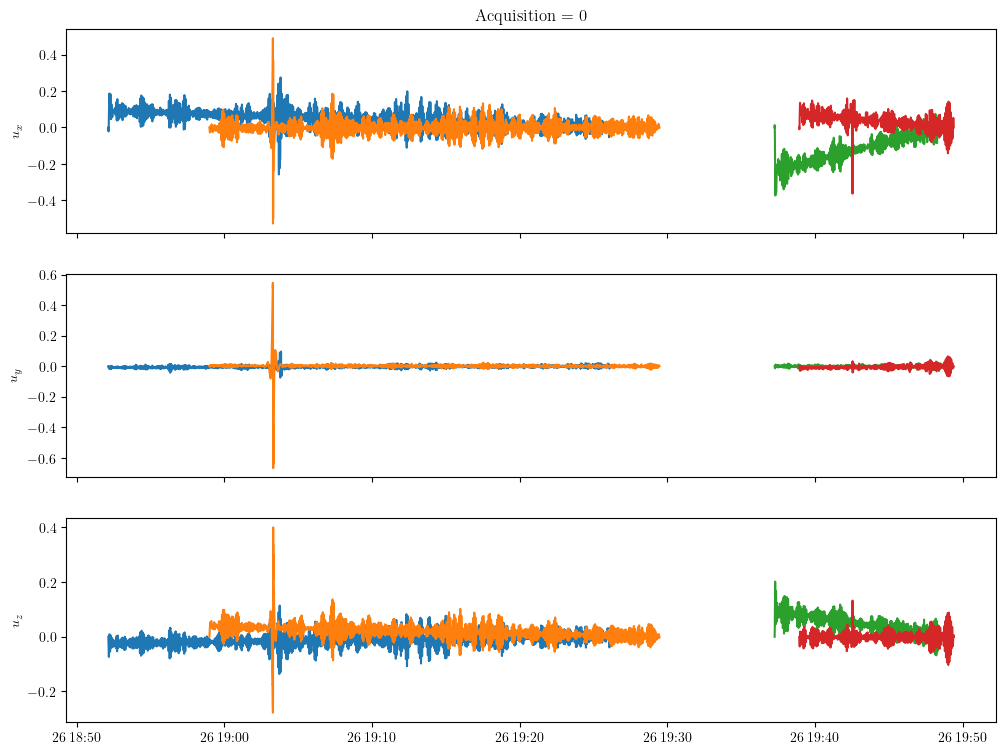

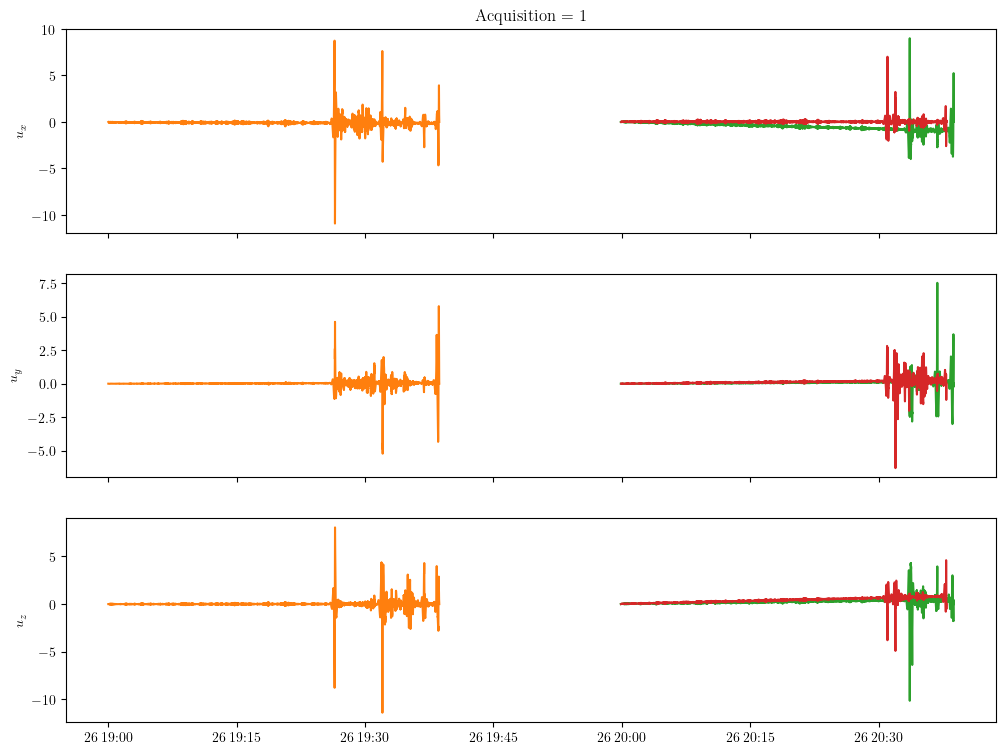

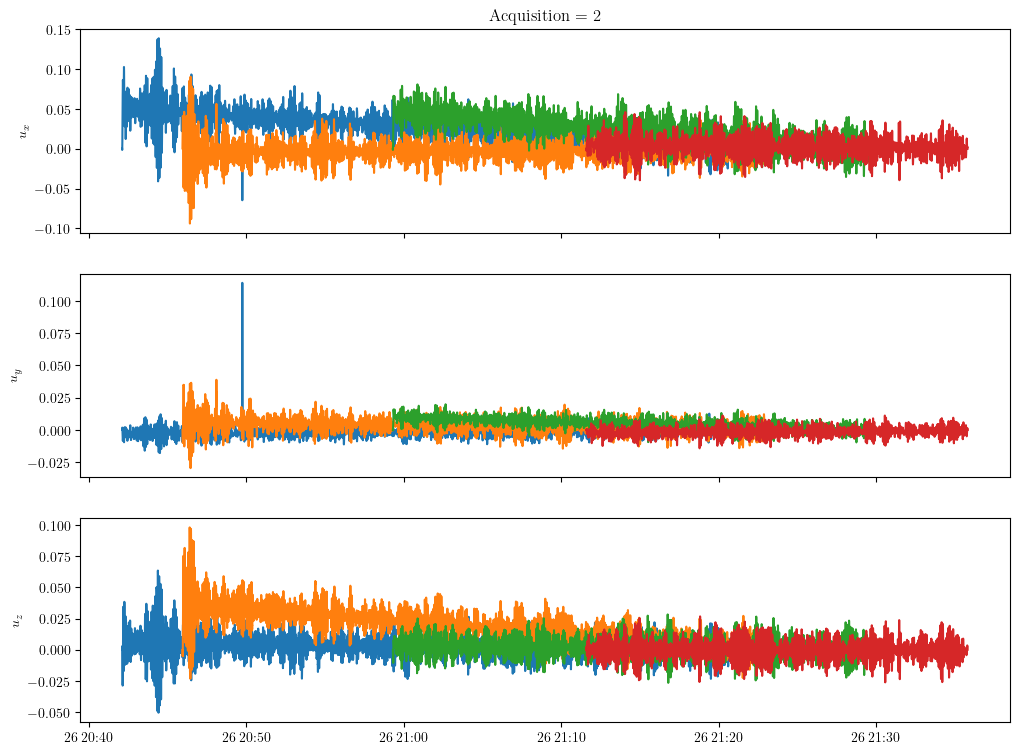

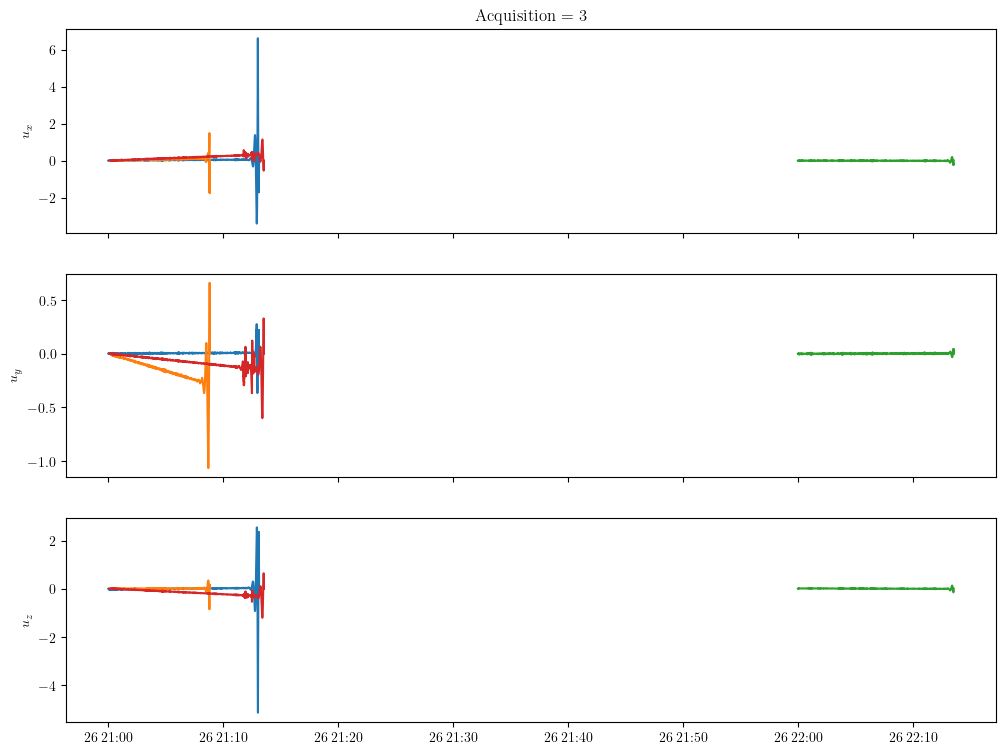

In [35]:
idx_u = 2 # 0 = u_x, 1 = u_y, 2 = u_z

key_buoys = list(u_buoy.keys())
color_table = ['tab:blue','tab:orange','tab:green','tab:red']
acquisition = np.arange(0,4)

outlier = 'B1_1900'

for acqu in range(4):
    fig, axs = plt.subplots(figsize = (12,9),ncols = 1, nrows = 3,sharex = True)
    
    for i in range(0 + acqu,len(key_buoys),4):
        print(i)
        key = key_buoys[i]
        current_color = color_table[i//4]
        print(i//4)
        if key != outlier :
            for idx_u in range(3):
                axs[idx_u].plot(UTC_buoy[key],u_buoy[key][idx_u,:],'-',color = current_color)
    
    axs[0].set_ylabel(r'$u_x$')
    axs[1].set_ylabel(r'$u_y$')
    axs[2].set_ylabel(r'$u_z$')
    axs[0].set_title(f'Acquisition = {acqu}')


### Load Drone data

In [12]:
drone_ID = 'mesange'
exp_ID = '12-FRAC_001'
path2drone = f'{base}{date}/Drones/{drone_ID}/matData/{exp_ID}/'
file2load = glob.glob(f'{path2drone}*scaled.h5')[0]

S = rw.load_dict_from_h5(file2load)

In [13]:
print(S.keys())
print(S['GPS'])

dict_keys(['DRONE', 'GPS', 'ID', 'PIV_param', 'PIXEL', 'SCALE', 'UTC_t', 'Vz', 'X', 'Y', 'err_uz', 'name', 't', 't0_UTC', 'units', 'ux', 'uz', 'x', 'xref', 'y', 'yref'])
{'azimuth': np.int64(170), 'latitude': np.float64(48.34836), 'longitude': np.float64(-68.81427), 'units': {'azimuth': 'deg[360]', 'latitude': 'deg', 'longitude': 'deg'}}


### Create UTC time array for drone

In [18]:
datetime_format = '%Y-%m-%d %H:%M:%S.%f'
UTC_0 = datetime.strptime(S['t0_UTC'] + '000',datetime_format)
UTC_0 = UTC_0.replace(tzinfo = pytz.utc)

t0_epoch_drone = UTC_0.timestamp()
t_epoch_drone = t0_epoch_drone + S['t']
UTC_drone = []
for t in t_epoch_drone:
    if not np.isnan(t):
        UTC_drone.append(datetime.fromtimestamp(t).replace(tzinfo = pytz.utc))


### Spatio temporal plot

Text(0, 0.5, '$x \\; \\mathrm{(m)}$')

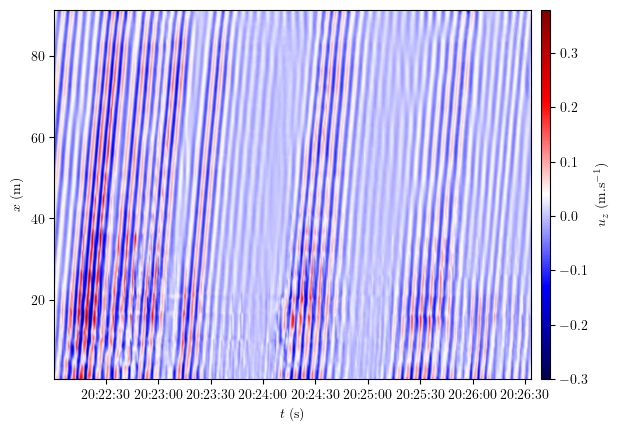

In [19]:
extents_spatio = [UTC_drone[0],UTC_drone[-1],S['x'][0],S['x'][-1]]
fig,ax = plt.subplots()
imsh = ax.imshow(S['uz'],origin = 'lower',aspect = 'auto',cmap = 'seismic',
          interpolation = 'gaussian',extent = extents_spatio)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)
cbar = plt.colorbar(imsh,cax = cax)
cbar.set_label(r'$u_z \; \mathrm{(m.s^{-1})}$')

ax.set_xlabel(r'$t \; \mathrm{(s)}$',labelpad = 5)
ax.set_ylabel(r'$x \; \mathrm{(m)}$',labelpad = 5)

### Compute buoys GPS positions

In [34]:
buoys_GPS = {}
key_nav = 'EKF_NAV'
for key_buoy in data_buoy.keys():
    
    lat = data_buoy[key_buoy][key_nav]['LATITUDE']
    long = data_buoy[key_buoy][key_nav]['LONGITUDE']
    
    buoys_GPS[key_buoy] = {}
    buoys_GPS[key_buoy]['latitude'] = np.mean(lat)
    buoys_GPS[key_buoy]['longitude'] = np.mean(long)

### Plot buoys GPS position and drone GPS positions

In [36]:
key_buoy[:2]

'B5'

In [73]:
S['GPS'].keys()

dict_keys(['latitude', 'longitude', 'units'])

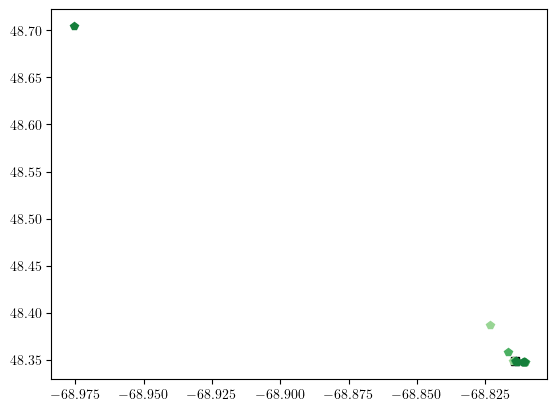

In [40]:
# create a dictionnary for buoy colors
norm = mcolors.Normalize(vmin = 0, vmax = 3)

cmap
full_cmap = mpl.colormaps['Greens'].resampled(256)
cmap = mcolors.ListedColormap(full_cmap(np.linspace(0.2,0.8,256)))

fig, ax = plt.subplots()

ax.plot(S['GPS']['longitude'],S['GPS']['latitude'],'ks')

for key_buoy in buoys_GPS.keys():

    buoy_idx = int(key_buoy[1])
    current_color = cmap(norm(buoy_idx))
    ax.plot(buoys_GPS[key_buoy]['longitude'],buoys_GPS[key_buoy]['latitude'],'p',color = current_color)